# Ein Hybridmodell mit LSTM-AE, DBSCAN und IF

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics import classification_report
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
import logging
from tensorflow.keras.layers import TimeDistributed, Dense, LSTM, Dropout, LayerNormalization, Input, Add, Bidirectional, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import balanced_accuracy_score
import sys
from keras.layers import LSTM, Dropout, LayerNormalization, Add, TimeDistributed, Dense
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from tensorflow.keras import backend as K

## 1. Vorbereitung

In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from sklearn.model_selection import StratifiedKFold

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

In [ ]:
# from dotenv import load_dotenv
# import requests
# import os

# event_url = os.environ.get("EVENT_URL")

# def get_all_events(token):
#     headers = {'Authorization': f'Bearer {token}'}
#     all_events = []
#     params = {'max': 5000}
#     resp = requests.get(event_url, headers=headers, params=params)
#     resp.raise_for_status()
#     batch = resp.json()
#     all_events.extend(batch)

#     return all_events

# server_url = os.environ.get("URL")
# client_id = os.environ.get("CLIENT_ID")
# client_secret = os.environ.get("CLIENT_SECRET")
# token_url = os.environ.get("TOKEN_URL")
# keycloak_url = os.environ.get("keycloak_url")
# authRealm = os.environ.get("authRealm")
# realm = os.environ.get("realm")

# load_dotenv()

# def get_token():
#     data = {
#         'keycloak_url': keycloak_url,
#         'authRealm': authRealm,
#         'realm': realm,
#         'client_id': client_id,
#         'client_secret': client_secret,
#         'grant_type': 'client_credentials'
#         }
#     resp = requests.post(token_url, data=data)
#     resp.raise_for_status()
#     token = resp.json()['access_token']
#     return token

# token = get_token()
# events = get_all_events(token)

In [ ]:
# from datetime import datetime
# import json


# filename = datetime.now().strftime("keycloak_events_%Y-%m-%d.jsonl")
# with open(filename, "a") as f:
#     for event in events:
#         f.write(json.dumps(event) + "\n")

#### Daten laden

In [ ]:
data_train = pd.read_json("train_logs.jsonl", lines=True)
data_test = pd.read_json("test_logs.jsonl", lines=True)
data_val = pd.read_json("val_logs.jsonl", lines=True)

In [ ]:
X_train_full = pd.DataFrame(data_train)
X_test_full = pd.DataFrame(data_test)
X_val_full = pd.DataFrame(data_val)

# data_test['label'] = data_test['details'].apply(lambda x: x.get('label', None))
# data_val['label'] = data_val['details'].apply(lambda x: x.get('label', None))
y_test_full = data_test["label"]
y_val_full = data_val["label"]

#### Automatisch alles in Numerische oder Kategorische Daten einteilen

In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

def is_missing(val):
    return val is None or (isinstance(val, float) and np.isnan(val))

def flatten_log_entry(log, parent_key='', sep='.'):
    items = []
    for k, v in log.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_log_entry(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

def auto_encode_features(logs, one_hot_numeric=False, label_encoders=None, onehot_encoders=None, fit=True):
    # Logs flach machen
    flat_logs = [flatten_log_entry(log) for log in logs]

    if label_encoders is None:
        label_encoders = {}
    if onehot_encoders is None:
        onehot_encoders = {}

    # Encoder vorbereiten
    for key in flat_logs[0].keys():
        values = []
        for log in flat_logs:
            val = log.get(key)

            if is_missing(val):
                val = "__MISSING__"
            elif isinstance(val, (list, dict)):
                print(f"Feature '{key}' enthält nicht-skalaren Wert – wird als String gespeichert: {val}")
                val = str(val)

            values.append(val)

        if fit:
            try:
                le = LabelEncoder()
                le.fit(values)
                label_encoders[key] = le
            except Exception as e:
                print(f"Fehler beim Enkodieren von Feature '{key}': {e}")
                continue

    # Feature-Werte transformieren
    encoded_logs = []
    for log in flat_logs:
        encoded_log = {}
        for key, le in label_encoders.items():
            val = log.get(key, "__MISSING__")
            if is_missing(val):
                val = "__MISSING__"
            elif isinstance(val, (list, dict)):
                val = str(val)
            try:
                encoded_log[key] = le.transform([val])[0]
            except ValueError:
                encoded_log[key] = -1  # unbekannte Kategorie
        encoded_logs.append(encoded_log)

    return encoded_logs, label_encoders, onehot_encoders

#### Werte aus vorheriger Funktion vereinigen

In [ ]:
def dicts_to_feature_matrix(encoded_logs):
    feature_names = sorted({key for d in encoded_logs for key in d.keys()})

    X = np.zeros((len(encoded_logs), len(feature_names)), dtype=np.float32)

    for i, d in enumerate(encoded_logs):
        for j, feat in enumerate(feature_names):
            if feat in d:
                X[i, j] = d[feat]

    return X, feature_names

In [ ]:
logs_train = X_train_full.to_dict(orient='records')
#logs_train = events
logs_test = X_test_full.to_dict(orient='records')
logs_val = X_val_full.to_dict(orient='records')

encoded_logs, label_encoders, onehot_encoders = auto_encode_features(
    logs_train, one_hot_numeric=False, fit=True
)
X_train, feature_names = dicts_to_feature_matrix(encoded_logs)

encoded_test_logs, _, _ = auto_encode_features(
    logs_test, one_hot_numeric=False,
    label_encoders=label_encoders, onehot_encoders=onehot_encoders, fit=False
)
X_test, _ = dicts_to_feature_matrix(encoded_test_logs)

encoded_val_logs, _, _ = auto_encode_features(
    logs_val, one_hot_numeric=False,
    label_encoders=label_encoders, onehot_encoders=onehot_encoders, fit=False
)
X_val, _ = dicts_to_feature_matrix(encoded_val_logs)

#### Skalierung

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

### Parameter

In [ ]:
seq_length = 50
batch_size = 32

encoder_layers = [128, 64]
decoder_layers = [64, 128]

dropout_rate = 0.1
learning_rate = 0.001

### Sequenzen

In [126]:
class SequenceToSequenceGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, seq_length, batch_size, pad_last=True):
        self.data = data
        self.seq_length = seq_length
        self.batch_size = batch_size
        self.pad_last = pad_last

        self.indices = np.arange(len(data) - seq_length)
        
        # Wenn Padding aktiv ist und etwas übrig bleibt
        if pad_last and (len(data) % seq_length != 0):
            self.include_last = True
        else:
            self.include_last = False

    def __len__(self):
        base = (len(self.indices) + self.batch_size - 1) // self.batch_size
        return base + (1 if self.include_last else 0)

    def __getitem__(self, idx):
        if idx < len(self) - 1 or not self.include_last:
            batch_idx = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
            X_batch = np.array([self.data[i:i + self.seq_length] for i in batch_idx])
        else:
            # letzte Sequenz mit Padding
            last_seq = self.data[-self.seq_length:]
            if len(last_seq) < self.seq_length:
                padding_len = self.seq_length - len(last_seq)
                padding = np.zeros((padding_len, self.data.shape[1]))
                last_seq = np.vstack((last_seq, padding))
            X_batch = np.expand_dims(last_seq, axis=0)

        return X_batch, X_batch

train_gen = SequenceToSequenceGenerator(X_train_scaled, seq_length, batch_size)
val_gen = SequenceToSequenceGenerator(X_val_scaled, seq_length, batch_size)
test_gen = SequenceToSequenceGenerator(X_test_scaled, seq_length, batch_size)

## 2. LSTM-AE implementieren

In [127]:
from tensorflow.keras.layers import Input, Bidirectional, LSTM, RepeatVector, TimeDistributed, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError

n_features = X_train_scaled.shape[1]

inputs = Input(shape=(seq_length, n_features))
x = inputs

# Tieferer Encoder mit bidirektionalen LSTMs
for units in encoder_layers:
    x = Bidirectional(LSTM(units, return_sequences=True))(x)
    x = Dropout(dropout_rate)(x)

# Letzte Encoder-Schicht ohne return_sequences, nur den letzten Output
encoded = Bidirectional(LSTM(encoder_layers[-1]))(x)

# Tieferer Decoder
x = RepeatVector(seq_length)(encoded)
for units in decoder_layers:
    x = Bidirectional(LSTM(units, return_sequences=True))(x)
    x = Dropout(dropout_rate)(x)

outputs = TimeDistributed(Dense(n_features, activation='linear'))(x)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate), loss='mse')
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 10, 18)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_18                │ (None, 10, 256)        │       150,528 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_19                │ (None, 10, 128)        │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_20                │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_4 (RepeatVector)  │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_21                │ (None, 10, 128)        │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_22                │ (None, 10, 256)        │       263,168 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 10, 18)         │         4,626 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 780,306 (2.98 MB)

 Trainable params: 780,306 (2.98 MB)

 Non-trainable params: 0 (0.00 B)

In [128]:
early_stop = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)
model.fit(train_gen, epochs=50, callbacks=[early_stop], validation_data=val_gen)

Epoch 1/50


/home/ueay/bachelorarbeit-projekt/env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


853/853 ━━━━━━━━━━━━━━━━━━━━ 67s 62ms/step - loss: 0.7870 - val_loss: 0.4982
Epoch 2/50
853/853 ━━━━━━━━━━━━━━━━━━━━ 55s 65ms/step - loss: 0.6837 - val_loss: 0.5550


### Umwandlung der Daten für nächste Modelle: Rekonstruktionsfehler berechnen

In [129]:
def get_reconstruction_errors(gen, model):
    errors = []
    for i in range(len(gen)):
        X_batch, _ = gen[i]
        pred = model.predict(X_batch, verbose=0)
        batch_errors = np.mean(np.square(X_batch - pred), axis=(1, 2))
        errors.extend(batch_errors)
    return np.array(errors)

train_errors = get_reconstruction_errors(train_gen, model)
val_errors = get_reconstruction_errors(val_gen, model)
test_errors = get_reconstruction_errors(test_gen, model)

reconstruction_errors = get_reconstruction_errors(test_gen, model)

In [130]:
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support, roc_auc_score
import numpy as np

y_test_seq = np.array([
    int(np.any(y_test_full[i : i + seq_length] == 1))
    for i in range(len(reconstruction_errors))
])
true_labels = y_test_seq.astype(int)

precisions, recalls, thresholds = precision_recall_curve(true_labels, reconstruction_errors)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)

best_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[best_idx]

y_pred = (reconstruction_errors > optimal_threshold).astype(int)

precision, recall, f1, _ = precision_recall_fscore_support(true_labels, y_pred, average='binary')
roc_auc = roc_auc_score(true_labels, reconstruction_errors)

print(f"Best Threshold by F1: {optimal_threshold:.5f}")
print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}, ROC-AUC: {roc_auc:.3f}")

Best Threshold by F1: 2.07340
Precision: 0.818, Recall: 0.773, F1: 0.795, ROC-AUC: 0.966


In [131]:
scaler_rec = StandardScaler()
scaler_rec.fit(train_errors.reshape(-1, 1))
val_errors_scaled = scaler_rec.transform(val_errors.reshape(-1, 1))
test_errors_scaled = scaler_rec.transform(test_errors.reshape(-1, 1))

# Modell 1

## Isolation Forest

In [132]:
iforest = IsolationForest(random_state=42)
iforest.fit(train_errors.reshape(-1, 1))

scores_if = iforest.decision_function(test_errors.reshape(-1, 1))
precisions_if, recalls_if, thresholds_if = precision_recall_curve(y_test_seq, -scores_if)
best_f1_scores_if = 2 * (precisions_if * recalls_if) / (precisions_if + recalls_if + 1e-10)
best_idx_if = np.argmax(best_f1_scores_if)
optimal_threshold_if = thresholds_if[best_idx_if]
y_pred_if = ((-scores_if) > optimal_threshold_if).astype(int)

precision_if, recall_if, f1_if, _ = precision_recall_fscore_support(y_test_seq, y_pred_if, average='binary')
roc_auc_if = roc_auc_score(y_test_seq, -scores_if)
pr_auc_if = average_precision_score(y_test_seq, y_pred_if)
fpr, tpr, _ = roc_curve(y_test_seq, y_pred_if)

mcc_if = matthews_corrcoef(y_test_seq, y_pred_if)
balanced_acc = balanced_accuracy_score(y_test_seq, y_pred_if)

print(f"IsolationForest Best Threshold by F1: {optimal_threshold_if:.5f}")
print(f"Precision: {precision_if:.3f}, Recall: {recall_if:.3f}, F1: {f1_if:.3f}, ROC-AUC: {roc_auc_if:.3f}, AUC-PR: {pr_auc_if}")
print(f"Matthews Correlation Coefficient: {mcc_if}, Balanced Accuracy: {balanced_acc}")

IsolationForest Best Threshold by F1: 0.18696
Precision: 0.824, Recall: 0.766, F1: 0.794, ROC-AUC: 0.955, AUC-PR: 0.635623697707966
Matthews Correlation Coefficient: 0.7896394583119458, Balanced Accuracy: 0.8809845055710306


### IF AUC-Kurven

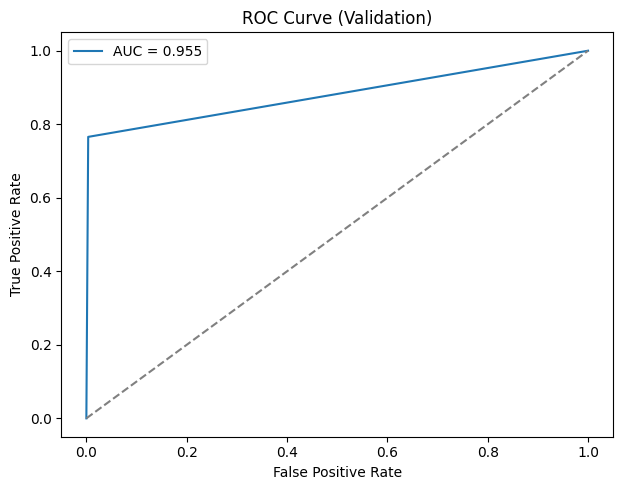

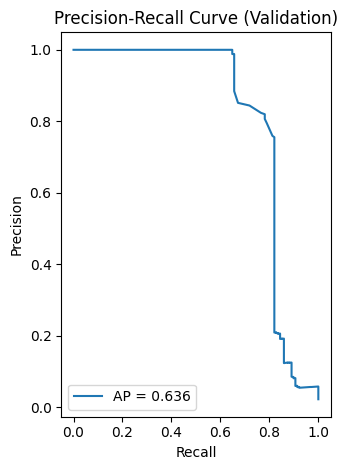

In [133]:
plt.figure(figsize=(12, 5))

# ROC Plot
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_if:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Validation)")
plt.legend()
plt.tight_layout()
#plt.savefig('roc_curve_if.png', dpi=300)
#plt.close()
plt.show()

# PR Plot
plt.subplot(1, 2, 2)
plt.plot(recalls_if, precisions_if, label=f"AP = {pr_auc_if:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Validation)")
plt.legend()
plt.tight_layout()
#plt.savefig('pr_curve_if.png', dpi=300)
#plt.close()
plt.show()

# Modell 2

## One-Class SVM

In [134]:
ocsvm = OneClassSVM()
ocsvm.fit(train_errors.reshape(-1,1))

scores_ocsvm = ocsvm.decision_function(test_errors.reshape(-1, 1))  # kleiner = anomal
precisions_ocsvm, recalls_ocsvm, thresholds_ocsvm = precision_recall_curve(y_test_seq, -scores_ocsvm)
f1_scores_ocsvm = 2 * (precisions_ocsvm * recalls_ocsvm) / (precisions_ocsvm + recalls_ocsvm + 1e-10)
best_idx_ocsvm = np.argmax(f1_scores_ocsvm)
optimal_threshold_ocsvm = thresholds_ocsvm[best_idx_ocsvm]

# Vorhersagen auf Testset
y_pred_ocsvm = ((-scores_ocsvm) > optimal_threshold_ocsvm).astype(int)

# Metriken
precision_ocsvm, recall_ocsvm, f1_ocsvm, _ = precision_recall_fscore_support(y_test_seq, y_pred_ocsvm, average='binary')
roc_auc_ocsvm = roc_auc_score(y_test_seq, -scores_ocsvm)
fpr, tpr, _ = roc_curve(y_test_seq, y_pred_ocsvm)
pr_auc = average_precision_score(y_test_seq, y_pred_ocsvm)

mcc_ocsvm = matthews_corrcoef(y_test_seq, y_pred_ocsvm)
balanced_acc = balanced_accuracy_score(y_test_seq, y_pred_ocsvm)

print(f"One-Class SVM Best Threshold by F1: {optimal_threshold_ocsvm:.5f}")
print(f"Precision: {precision_ocsvm:.3f}, Recall: {recall_ocsvm:.3f}, F1: {f1_ocsvm:.3f}, ROC-AUC: {roc_auc_ocsvm:.3f}, MCC: {mcc_ocsvm:.3f}, Balanced Accuracy: {balanced_acc}")

One-Class SVM Best Threshold by F1: 3971.67902
Precision: 0.818, Recall: 0.773, F1: 0.795, ROC-AUC: 0.907, MCC: 0.791, Balanced Accuracy: 0.8848037082172702


### OCSVM AUC-Kurven

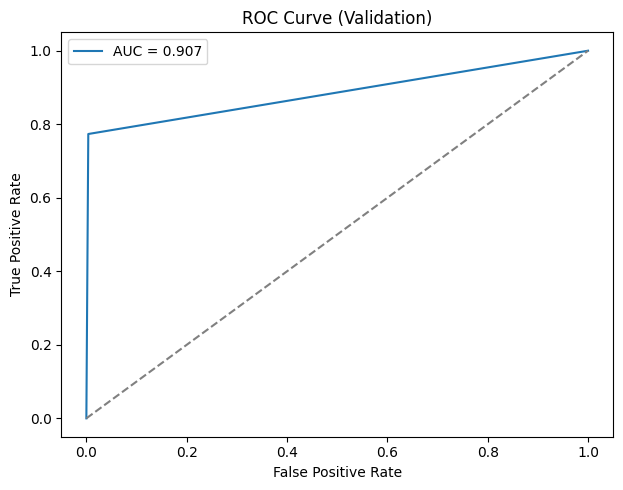

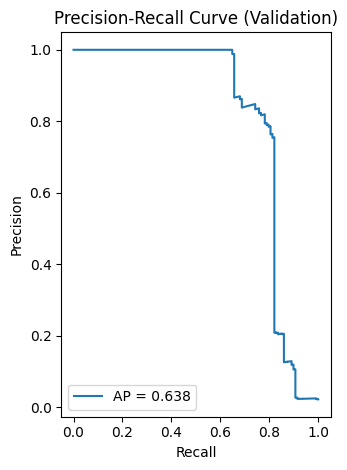

In [135]:
# Plotten
plt.figure(figsize=(12, 5))

# ROC OCSVM
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_ocsvm:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Validation)")
plt.legend()
plt.tight_layout()
#plt.savefig('roc_curve_ocsvm.png', dpi=300)
#plt.close()
plt.show()

# PR OCSVM
plt.subplot(1, 2, 2)
plt.plot(recalls_ocsvm, precisions_ocsvm, label=f"AP = {pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Validation)")
plt.legend()
plt.tight_layout()
#plt.savefig('pr_curve_ocsvm.png', dpi=300)
#plt.close()
plt.show()

# Modell 3

## DBSCAN

In [136]:
dbscan = DBSCAN()
labels = dbscan.fit_predict(test_errors.reshape(-1,1))
dbscan_scores = test_errors  # höhere Fehler = wahrscheinliche Anomalie

# F1-basierter Threshold
precisions_dbscan, recalls_dbscan, thresholds_dbscan = precision_recall_curve(y_test_seq, dbscan_scores)
f1_scores_dbscan = 2 * (precisions_dbscan * recalls_dbscan) / (precisions_dbscan + recalls_dbscan + 1e-10)
best_idx_dbscan = np.argmax(f1_scores_dbscan)
optimal_threshold_dbscan = thresholds_dbscan[best_idx_dbscan]

# Vorhersage
y_pred_dbscan = (labels == -1).astype(int)  # 1 = Anomalie, 0 = normal
precision_dbscan, recall_dbscan, f1_dbscan, _ = precision_recall_fscore_support(y_test_seq, y_pred_dbscan, average='binary')
fpr, tpr, _ = roc_curve(y_test_seq, y_pred_dbscan)
roc_auc = roc_auc_score(y_test_seq, y_pred_dbscan)
pr_auc = average_precision_score(y_test_seq, y_pred_dbscan)

mcc_dbscan = matthews_corrcoef(y_test_seq, y_pred_dbscan)
balanced_acc = balanced_accuracy_score(y_test_seq, y_pred_dbscan)

print(f"DBSCAN Best Threshold by F1: {optimal_threshold_dbscan:.5f}")
print(f"Precision: {precision_dbscan:.3f}, Recall: {recall_dbscan:.3f}, F1: {f1_dbscan:.3f}, MCC: {mcc_dbscan:.3f}, Balanced Accuracy: {balanced_acc:.3f}")

DBSCAN Best Threshold by F1: 2.07340
Precision: 1.000, Recall: 0.156, F1: 0.270, MCC: 0.392, Balanced Accuracy: 0.578


### DBSCAN AUC-Kurven

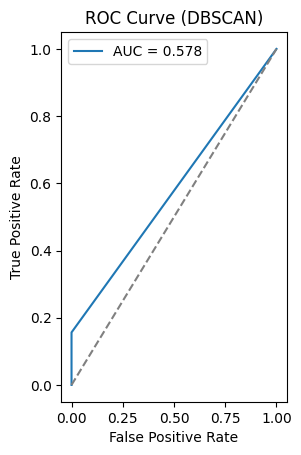

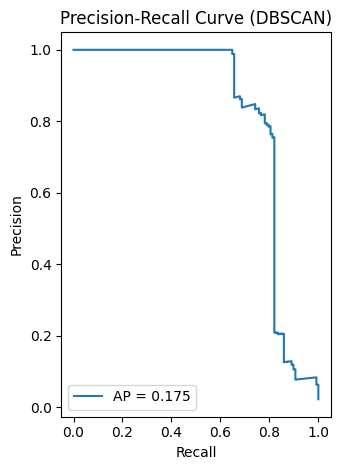

In [137]:
# ROC-Kurve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (DBSCAN)")
plt.legend()
#plt.savefig('roc_curve_dbscan.png', dpi=300)
#plt.close()
plt.show()

# PR-Kurve
plt.subplot(1, 2, 2)
plt.plot(recalls_dbscan, precisions_dbscan, label=f"AP = {pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (DBSCAN)")
plt.legend()
plt.tight_layout()
#plt.savefig('pr_curve_dbscan.png', dpi=300)
#plt.close()
plt.show()

## Cross Validation Test

### Für LSTM-AE und IF

In [ ]:
from sklearn.model_selection import KFold
from sklearn.ensemble import IsolationForest
import numpy as np

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

all_precisions, all_recalls, all_f1s, all_roc_aucs = [], [], [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_test_full)):
    print(f"Fold {fold + 1}/{n_splits}")

    model.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=[early_stop], verbose=0)

    iforest = IsolationForest()
    iforest.fit(train_errors.reshape(-1, 1))

    test_preds_if = iforest.predict(test_errors.reshape(-1, 1))
    val_anomaly_if = (test_preds_if == -1).astype(int)

    y_test_seq_if = np.array([y_test_full[i + seq_length- 1] for i in range(len(val_anomaly_if))])
    true_labels_if = y_test_seq_if.astype(int)

    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, y_pred, average='binary')
    roc_auc = roc_auc_score(true_labels, iforest.decision_function(test_errors.reshape(-1, 1)) * -1)

    all_precisions.append(precision)
    all_recalls.append(recall)
    all_f1s.append(f1)
    all_roc_aucs.append(roc_auc)

    print(f"Mean Precision: {np.mean(all_precisions):.3f} ± {np.std(all_precisions):.3f}")
    print(f"Mean Recall: {np.mean(all_recalls):.3f} ± {np.std(all_recalls):.3f}")
    print(f"Mean F1-Score: {np.mean(all_f1s):.3f} ± {np.std(all_f1s):.3f}")
    print(f"Mean ROC-AUC: {np.mean(all_roc_aucs):.3f} ± {np.std(all_roc_aucs):.3f}")

### Für LSTM-AE und OCSVM

In [ ]:
from sklearn.model_selection import KFold
from sklearn.ensemble import IsolationForest
import numpy as np

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

all_precisions, all_recalls, all_f1s, all_roc_aucs = [], [], [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_test_full)):
    print(f"Fold {fold + 1}/{n_splits}")

    model.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=[early_stop], verbose=0)
    ocsvm = OneClassSVM(nu=0.005, gamma=50)
    ocsvm.fit(train_errors.reshape(-1, 1))

    test_preds_ocsvm = ocsvm.predict(test_errors.reshape(-1, 1))
    test_anomaly_ocsvm = (test_preds_ocsvm == -1).astype(int)

    y_test_seq_ocsvm = np.array([y_test_full[i + seq_length - 1] for i in range(len(test_anomaly_ocsvm))])
    true_labels_ocsvm = y_test_seq.astype(int)

    report_ocsvm = classification_report(true_labels_ocsvm, test_anomaly_ocsvm)

    all_precisions.append(precision)
    all_recalls.append(recall)
    all_f1s.append(f1)
    all_roc_aucs.append(roc_auc)

    print(f"Mean Precision: {np.mean(all_precisions):.3f} ± {np.std(all_precisions):.3f}")
    print(f"Mean Recall: {np.mean(all_recalls):.3f} ± {np.std(all_recalls):.3f}")
    print(f"Mean F1-Score: {np.mean(all_f1s):.3f} ± {np.std(all_f1s):.3f}")
    print(f"Mean ROC-AUC: {np.mean(all_roc_aucs):.3f} ± {np.std(all_roc_aucs):.3f}")

### Für LSTM-AE und DBSCAN

In [ ]:
from sklearn.model_selection import KFold
from sklearn.ensemble import IsolationForest
import numpy as np

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

all_precisions, all_recalls, all_f1s, all_roc_aucs = [], [], [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_test_full)):
    print(f"Fold {fold + 1}/{n_splits}")

    model.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=[early_stop], verbose=0)
    dbscan = DBSCAN(eps = 0.05, min_samples = 40)

    dbscan_labels = dbscan.fit_predict(test_errors.reshape(-1, 1))
    dbscan_anomaly = (dbscan_labels == -1).astype(int)

    y_test_seq_dbscan = np.array([y_test_full[i + seq_length - 1] for i in range(len(dbscan_anomaly))])
    true_labels_dbscan = y_test_seq_dbscan.astype(int)
    
    all_precisions.append(precision)
    all_recalls.append(recall)
    all_f1s.append(f1)
    all_roc_aucs.append(roc_auc)

    print(f"Mean Precision: {np.mean(all_precisions):.3f} ± {np.std(all_precisions):.3f}")
    print(f"Mean Recall: {np.mean(all_recalls):.3f} ± {np.std(all_recalls):.3f}")
    print(f"Mean F1-Score: {np.mean(all_f1s):.3f} ± {np.std(all_f1s):.3f}")
    print(f"Mean ROC-AUC: {np.mean(all_roc_aucs):.3f} ± {np.std(all_roc_aucs):.3f}")